In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


### Read the CSV

In [3]:
test = pd.read_csv("final_data/densenet_valid_embeddings.csv")
train = pd.read_csv("final_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(test.columns)
test.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient42140/study4/view1_frontal.jpg,train/patient42140/study4/view1_frontal.dcm,58.0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,"[0.0, 0.09216563403606415, 0.29301267862319946..."
1,train/patient47493/study1/view1_frontal.jpg,train/patient47493/study1/view1_frontal.dcm,83.0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,"[0.0013288786867633462, 0.11045646667480469, 0..."
2,train/patient15684/study7/view1_frontal.jpg,train/patient15684/study7/view1_frontal.dcm,51.0,1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,"[8.94162876647897e-05, 0.0020118376705795527, ..."
3,train/patient36696/study7/view1_frontal.jpg,train/patient36696/study7/view1_frontal.dcm,27.0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,"[0.0006279312656261027, 0.06884142756462097, 0..."
4,train/patient13676/study11/view1_frontal.jpg,train/patient13676/study11/view1_frontal.dcm,73.0,1,2,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,"[0.0, 0.08706286549568176, 0.2090015709400177,..."


### Convert embeddings from str to list (a bit long for large data sets)

In [4]:
test['embeddings'] = test['embeddings'].apply(ast.literal_eval)

In [5]:
train['embeddings'] = train['embeddings'].apply(ast.literal_eval)

### Remove columns

In [6]:
test = test.drop(columns=['path_to_image', 'path_to_dcm'])
train = train.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [7]:
initial_size = test.shape[0] 

# The previous logic with transforming the list to string and filtering on the length of said string is not necessarily stable and misleading.
# Let's implement a more explicit test for what we actually care about: 

test = test[test['embeddings'].apply(type) == list]

final_size = test.shape[0] 

print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 

train = train[train['embeddings'].apply(type) == list]

final_size = train.shape[0] 

print(f'Number of train removed rows = {initial_size - final_size}')

Number of test removed rows = 3
Number of train removed rows = 51


In [8]:
test.shape

(4481, 19)

### Train test

In [9]:

# # Using Random Forest as the base estimator
# base_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# # Multi-output classifier
# multi_target_rf = MultiOutputClassifier(base_rf, n_jobs=-1)

# # Train the model
# multi_target_rf.fit(train_embeddings, y_train)

# # Predict on test data
# predictions = multi_target_rf.predict(test_embeddings)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, predictions))
# print("F1 Score:", f1_score(y_test, predictions, average='micro'))
# print("Recall:", recall_score(y_test, predictions, average='micro'))
# print("Precision:", precision_score(y_test, predictions, average='micro'))


In [10]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist(), columns=[f'embedding_{i}' for i in range(1024)])
test_embeddings = pd.DataFrame(test['embeddings'].tolist(), columns=[f'embedding_{i}' for i in range(1024)])

# Diseases to predict
diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]

# Create x_train and x_test
x_train = pd.concat([train.reset_index(), train_embeddings], axis=1)
x_test =  pd.concat([test.reset_index(), test_embeddings], axis=1)

x_train.drop(columns=["embeddings"] + diseases, inplace=True)
x_test.drop(columns=["embeddings"] + diseases, inplace=True)

# Create some backups:
_x_train, _x_test, _y_train, _y_test = x_train.copy(deep=True), x_test.copy(deep=True), y_train.copy(deep=True), y_test.copy(deep=True)
# To restore the backups, run:
# x_train, x_test, y_train, y_test = _x_train.copy(deep=True), _x_test.copy(deep=True), _y_train.copy(deep=True), _y_test.copy(deep=True)



PCA used with 10 components.
      Iter       Train Loss   Remaining Time 
         1           0.3576            0.19s
         2           0.3544            0.19s
         3           0.3519            0.18s
         4           0.3480            0.17s
         5           0.3450            0.16s
         6           0.3349            0.16s
      Iter       Train Loss   Remaining Time 
         1           0.7310            0.18s
         2           0.7102            0.18s
         3           0.6925            0.17s
         4           0.6790            0.16s
         5           0.6675            0.16s
         6           0.6579            0.15s
         7           0.6489            0.15s
         8           0.6383            0.14s
         9           0.6307            0.13s
        10           0.6236            0.13s
        20           0.5684            0.06s
        30           0.5304            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.

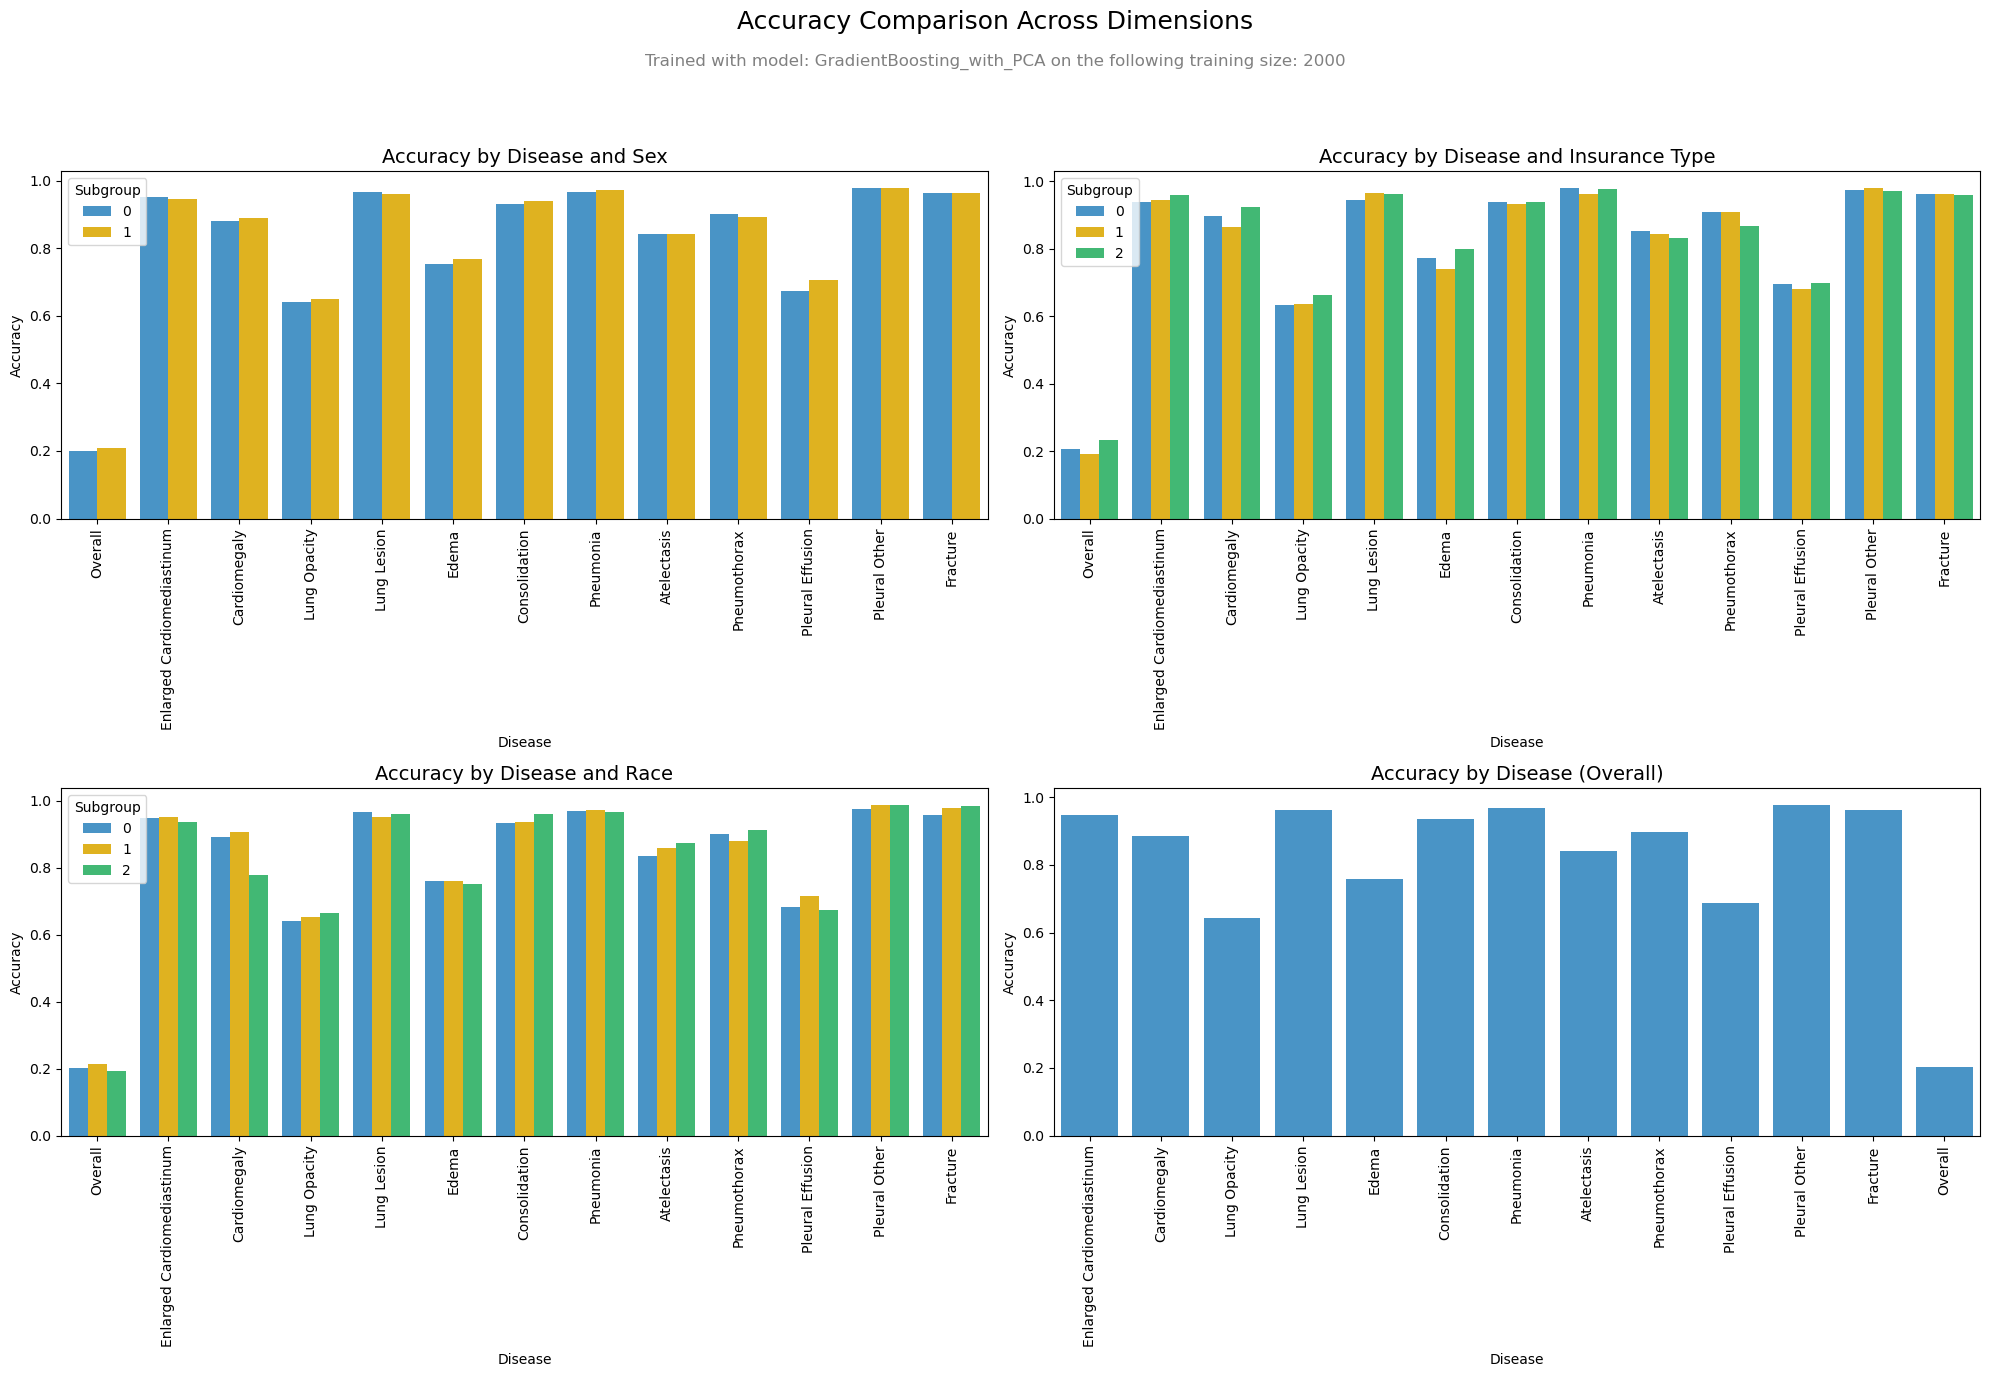

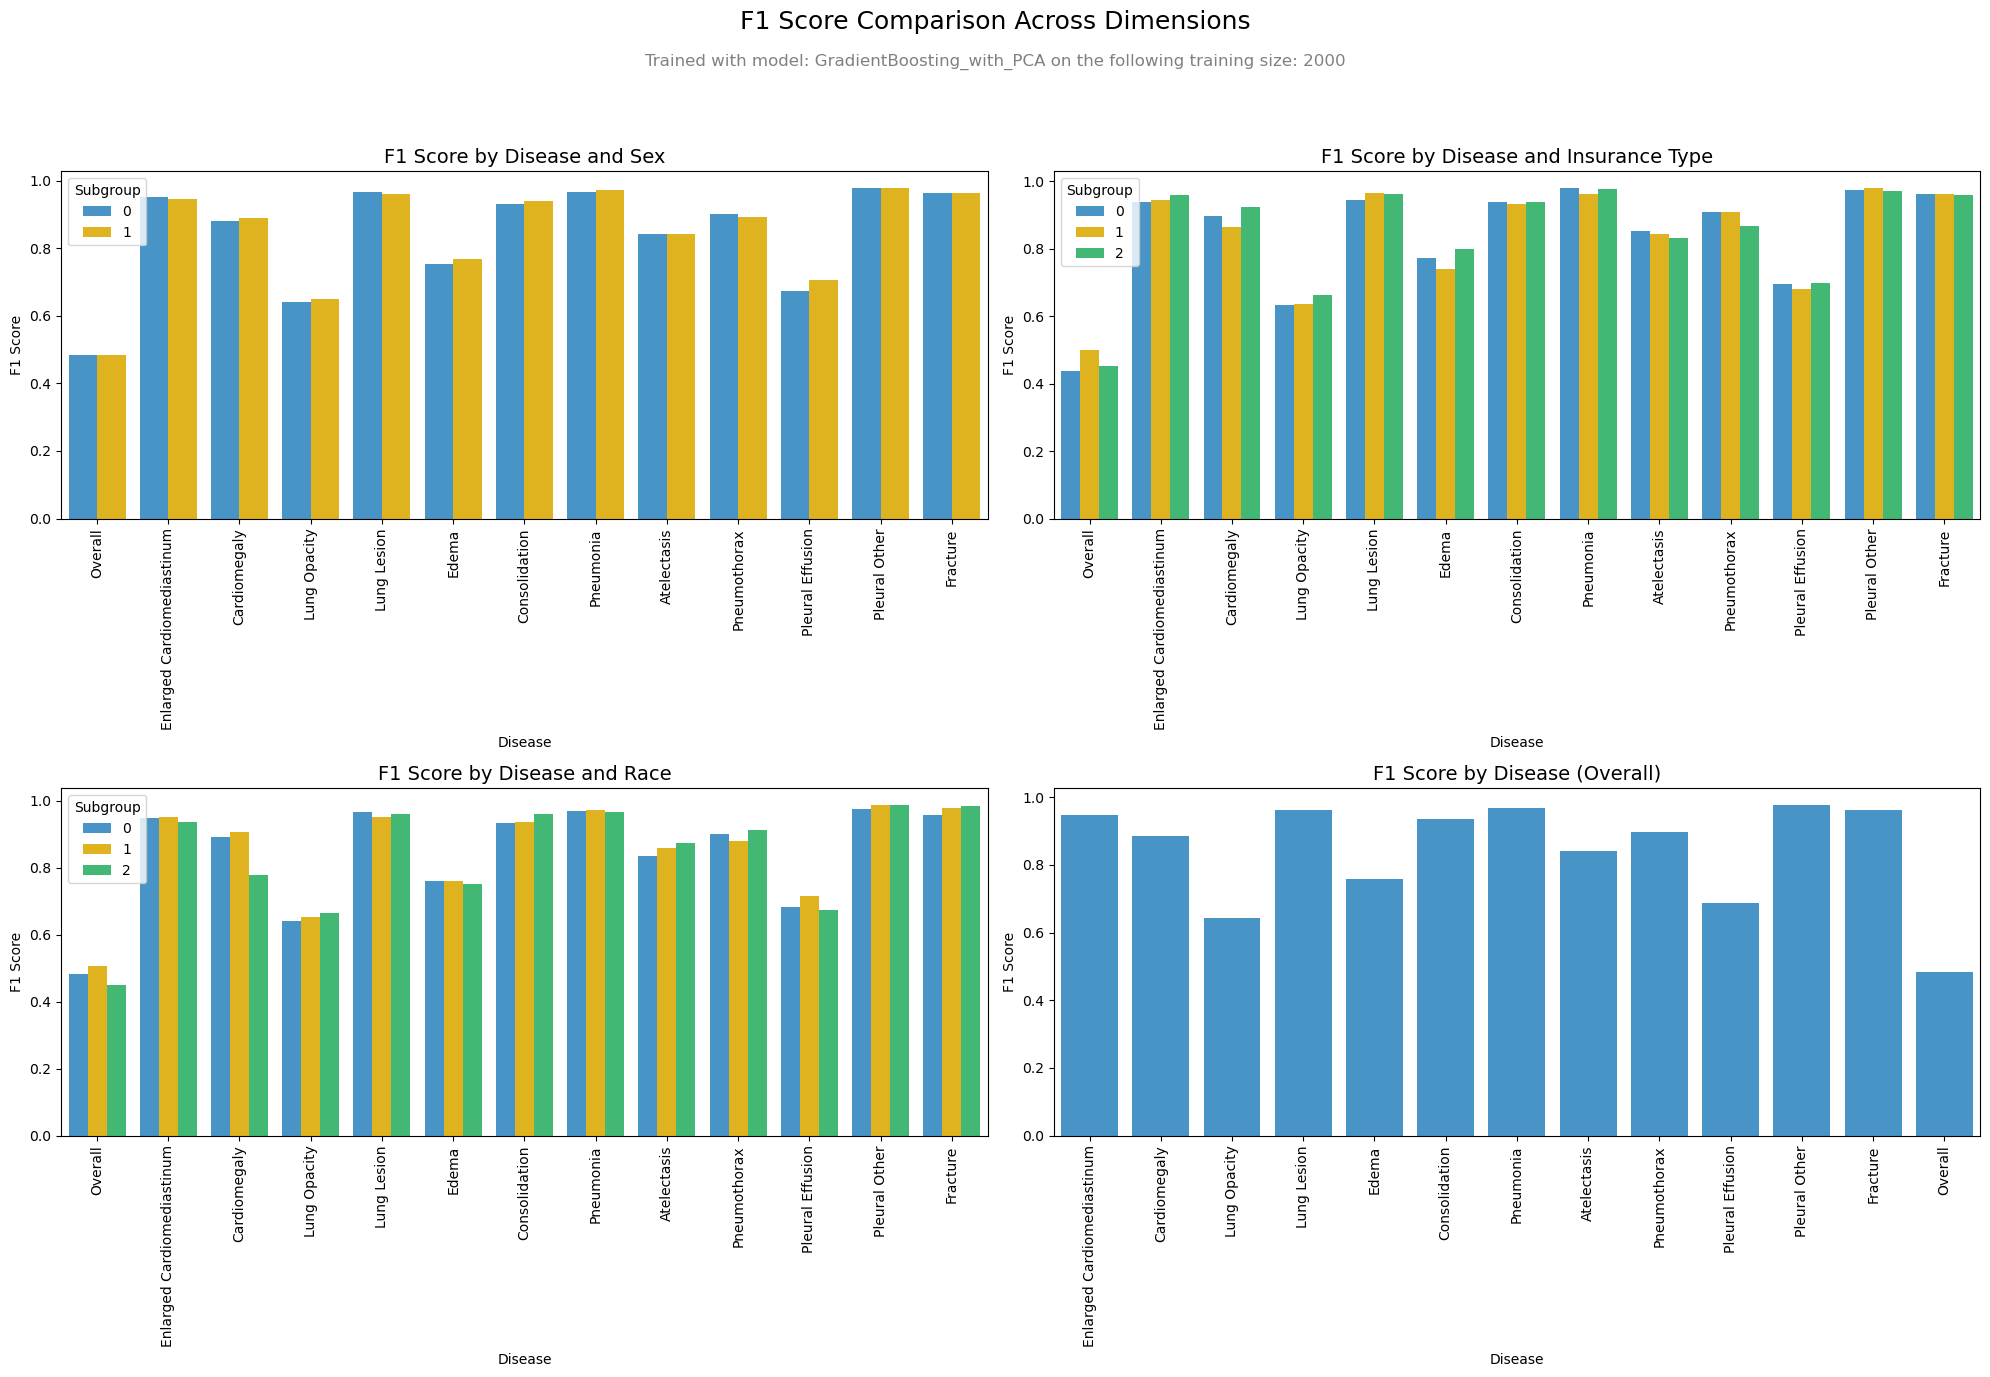

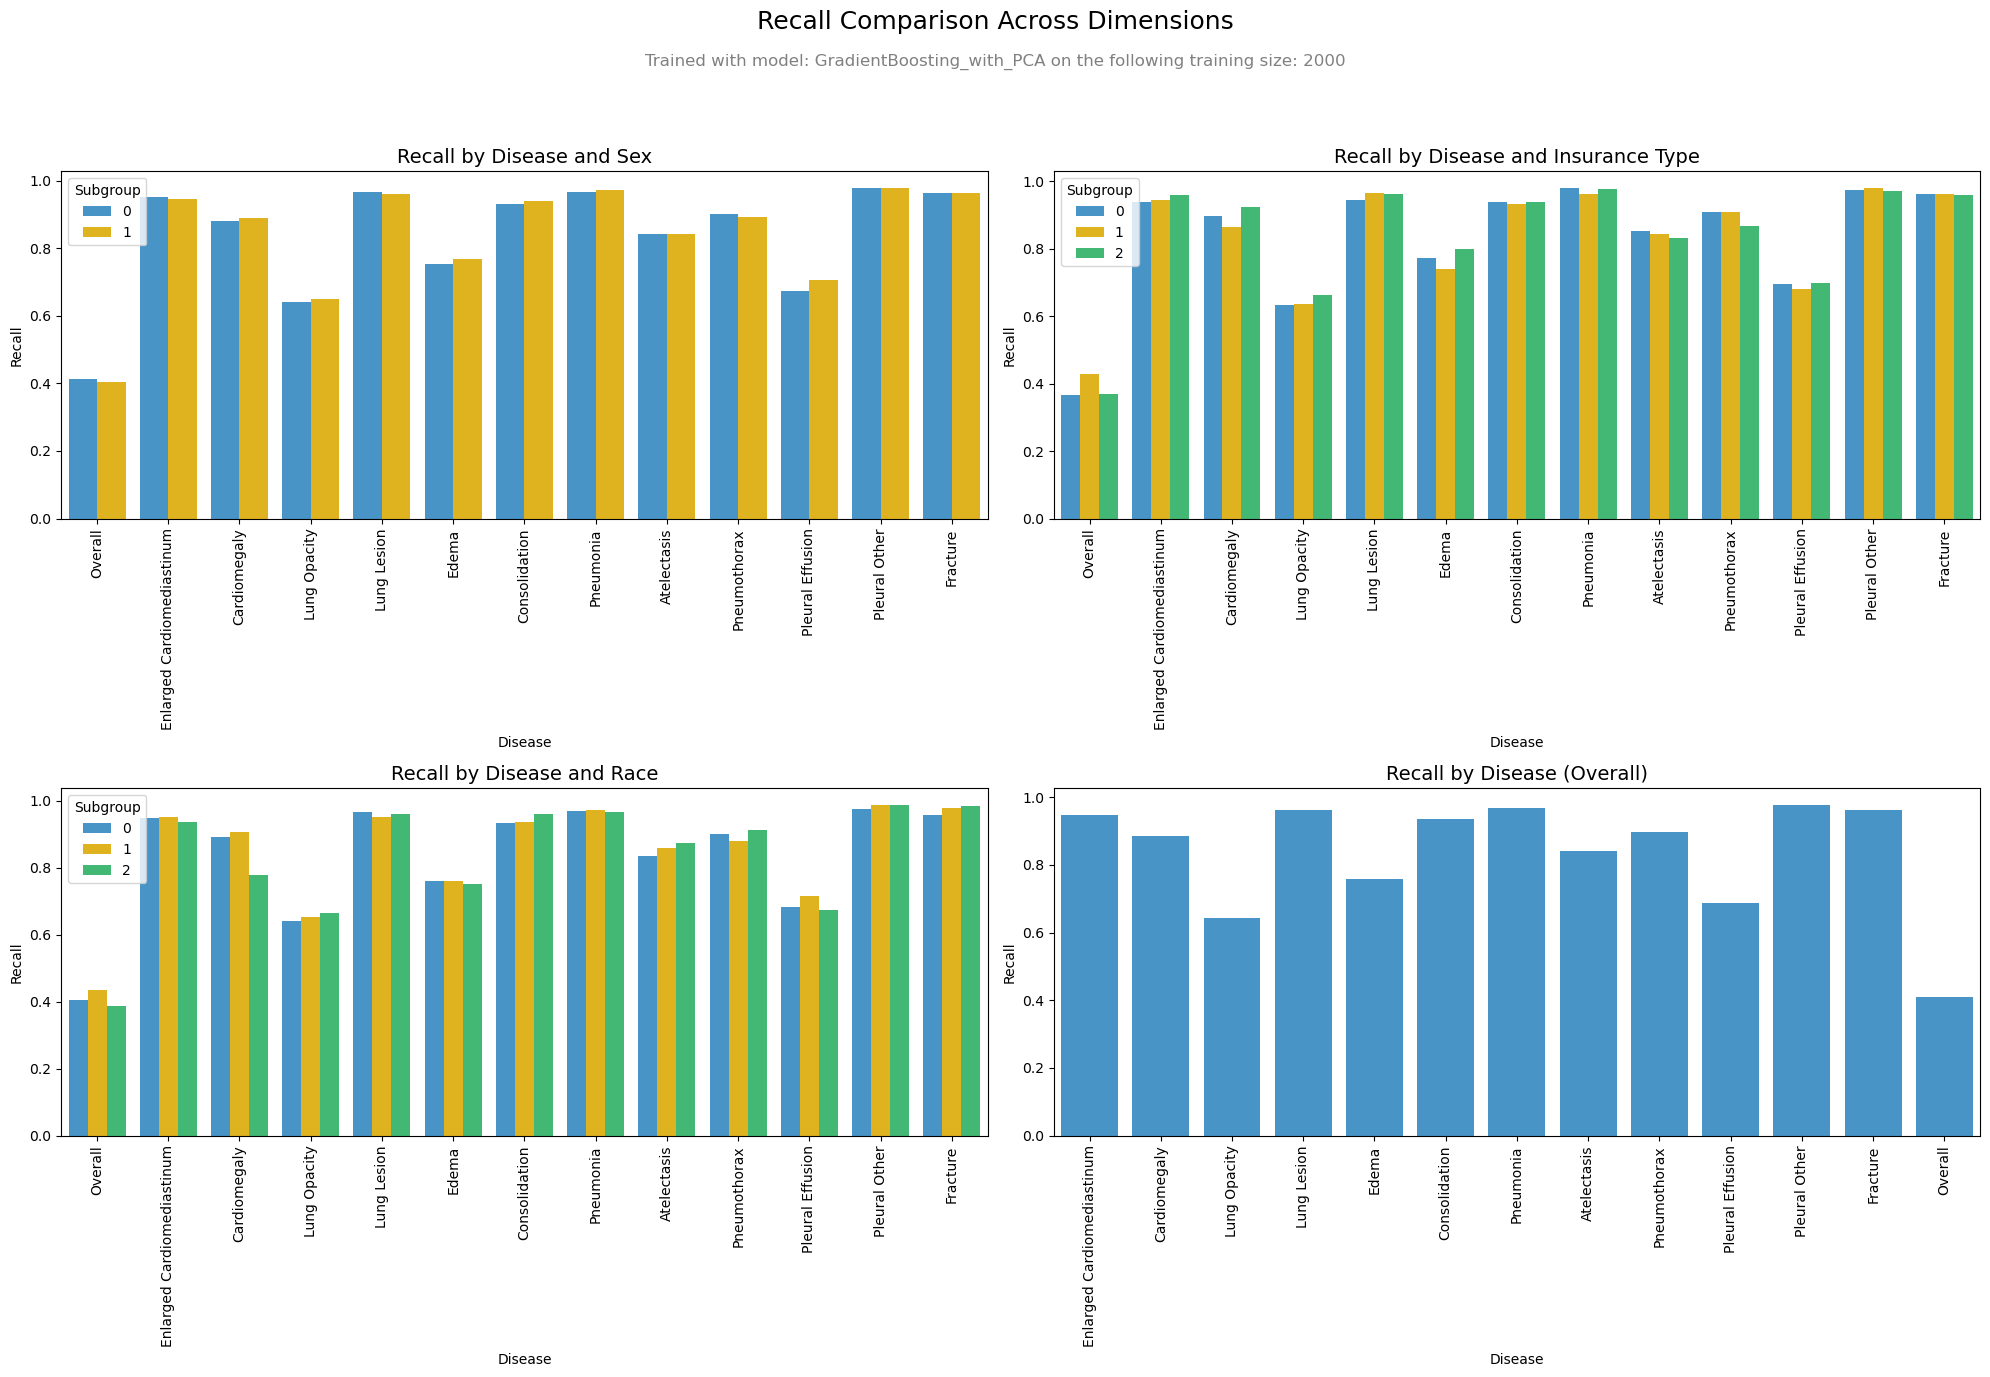

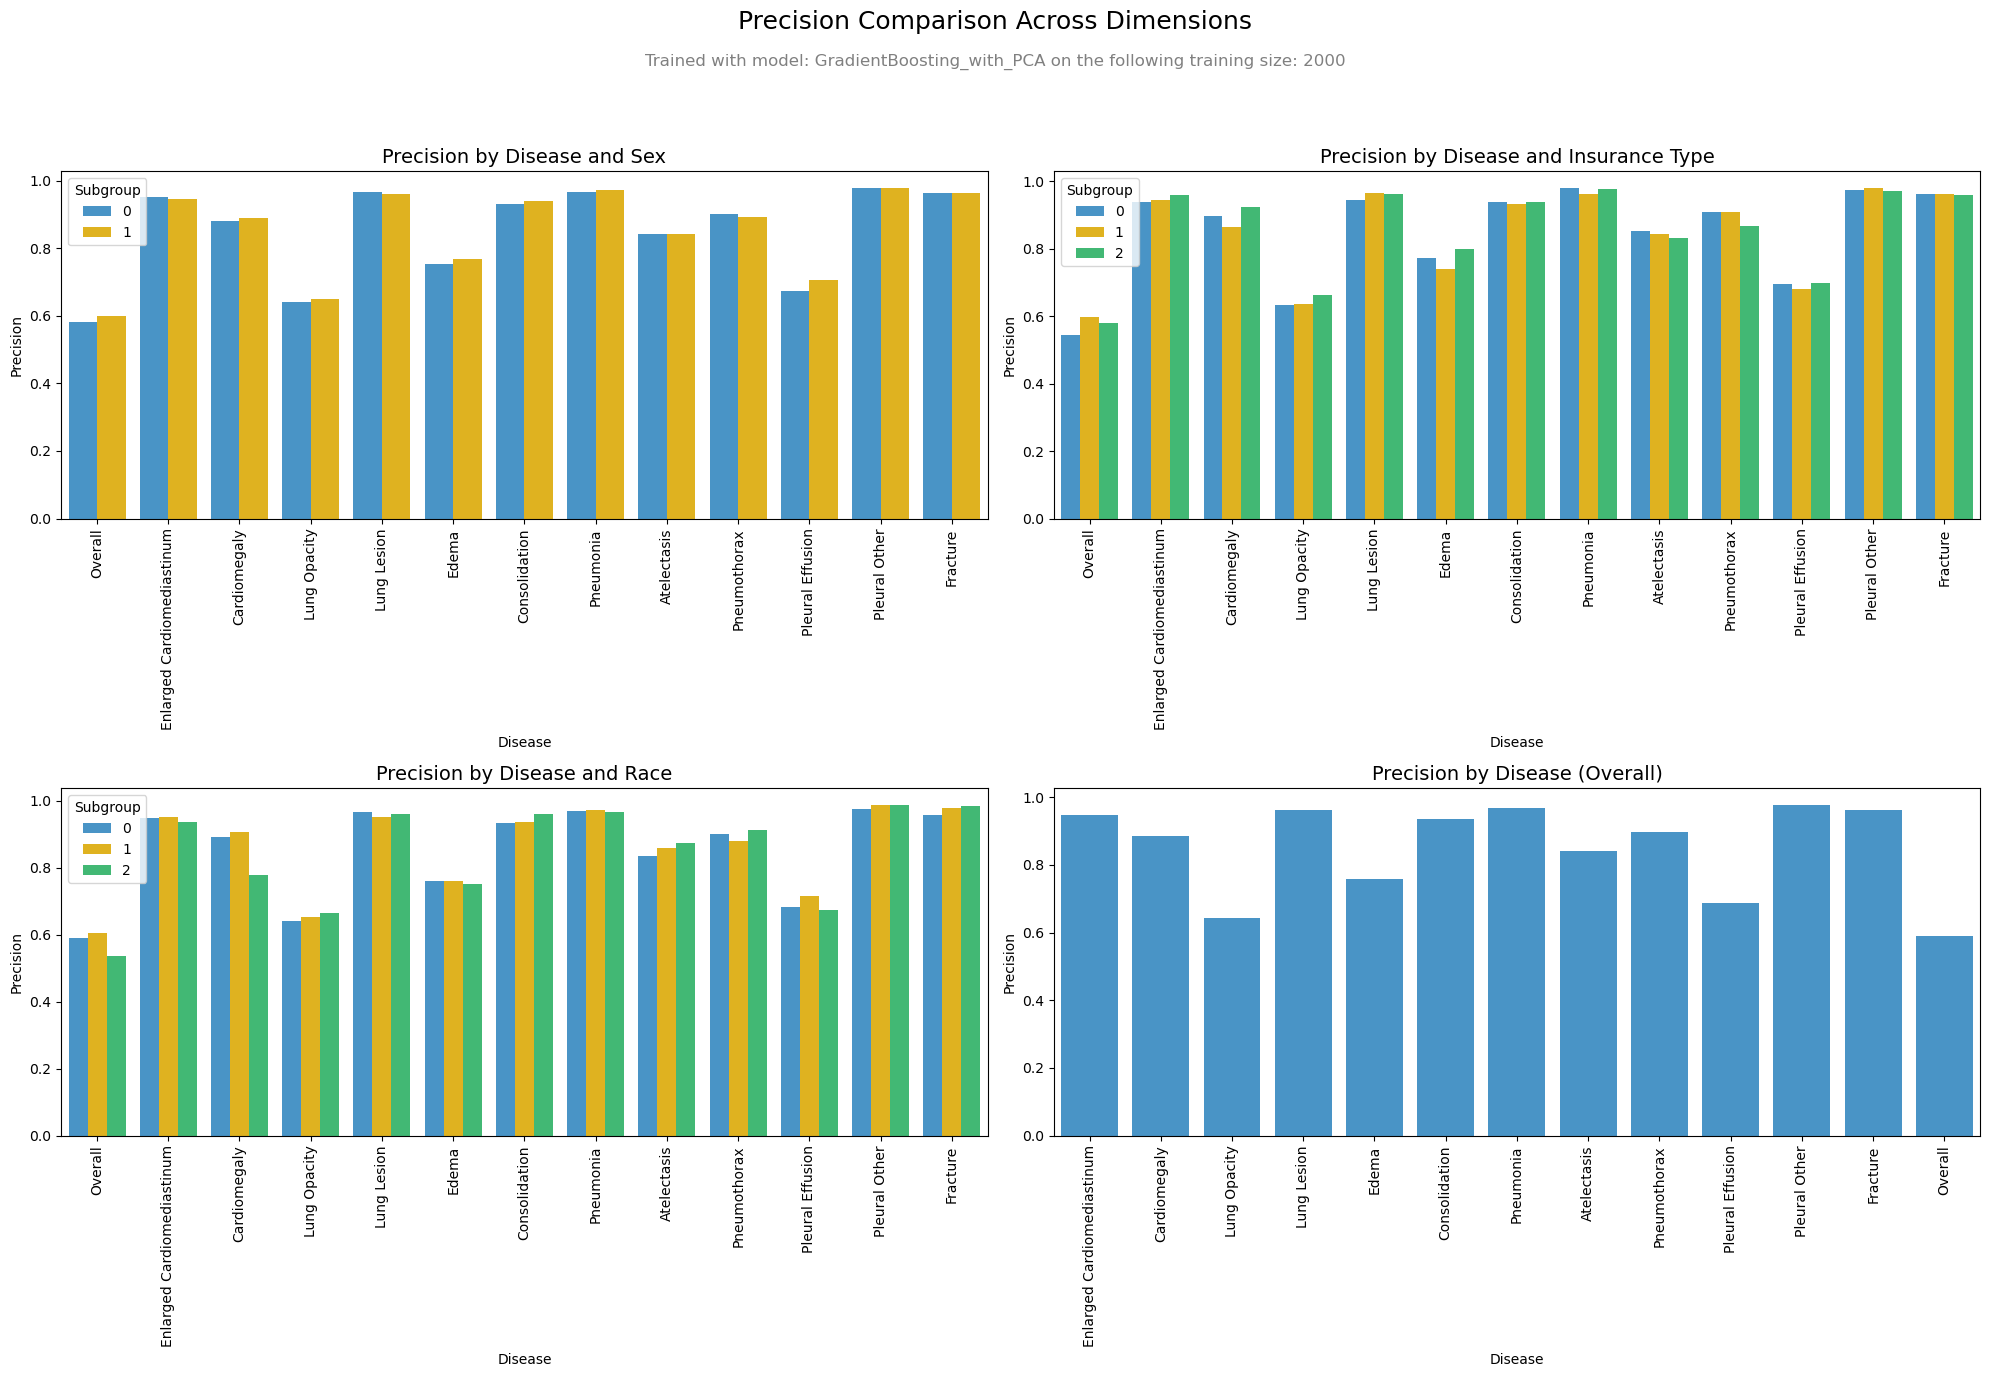

In [30]:
diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 
            'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
            'Pleural Effusion', 'Pleural Other', 'Fracture']

def train_model(x_train, y_train, x_test, y_test, model, metric_dimensions=[], columns_to_drop=[], n_components=None):
    multi_output_model = MultiOutputClassifier(model)
    x_test = x_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    x_train_subset = x_train.drop(columns=columns_to_drop, errors='ignore')
    x_test_subset = x_test.drop(columns=columns_to_drop, errors='ignore')
    
    # Apply PCA if specified
    if n_components:
        pca = PCA(n_components=n_components)
        x_train_subset = pca.fit_transform(x_train_subset)
        x_test_subset = pca.transform(x_test_subset)
        print(f"PCA used with {n_components} components.")
    else:
        print("PCA not used.")

    # Prepare to store all metrics
    metrics_data = {
        'Metric Dimension': [],
        'Subgroup': [],
        'Disease': [],
        'Accuracy': [],
        'F1 Score': [],
        'Recall': [],
        'Precision': []
    }

    def calculate_metrics(y_true, y_pred, disease_label="Overall"):
        """ Helper function to calculate metrics and add them to metrics_data """
        metrics_data['Metric Dimension'].append(metric_dim)
        metrics_data['Subgroup'].append(subgroup)
        metrics_data['Disease'].append(disease_label)
        metrics_data['Accuracy'].append(accuracy_score(y_true, y_pred))
        metrics_data['F1 Score'].append(f1_score(y_true, y_pred, average='micro'))
        metrics_data['Recall'].append(recall_score(y_true, y_pred, average='micro'))
        metrics_data['Precision'].append(precision_score(y_true, y_pred, average='micro'))

    # Train the model on the full dataset
    try:
        multi_output_model.fit(x_train_subset, y_train)
        # Make predictions
        y_test_preds = pd.DataFrame(multi_output_model.predict(x_test_subset), columns=diseases)
        metric_dim, subgroup = "all", "all"
        calculate_metrics(y_test, y_test_preds)
        # Calculate metrics for each disease individually
        for disease in diseases:
            calculate_metrics(y_test[disease], y_test_preds[disease], disease_label=disease)
    except ValueError:
        print("Multi-output not supported. Training each disease separately.")
        for disease in diseases:
            model.fit(x_train_subset, y_train[disease])
            y_test_preds = model.predict(x_test_subset)
            metric_dim, subgroup = "all", "all"
            calculate_metrics(y_test[disease], y_test_preds, disease_label=disease)

    # Calculate metrics for each dimension in `metric_dimensions`
    for metric_dim in metric_dimensions:
        for subgroup in x_test[metric_dim].unique():
            # Create a boolean mask for the subgroup
            mask = (x_test[metric_dim] == subgroup)
            x_test_subgroup = x_test_subset[mask]
            y_test_subgroup = y_test.loc[mask]
            try:
                y_test_preds_subgroup = y_test_preds.loc[mask]
                calculate_metrics(y_test_subgroup, y_test_preds_subgroup)
                for disease in diseases:
                    calculate_metrics(y_test_subgroup[disease], y_test_preds_subgroup[disease], disease_label=disease)
            except Exception:
                for disease in diseases:
                    y_test_subgroup_disease = y_test_subgroup[disease]
                    y_test_preds_disease = model.predict(x_test_subgroup)
                    calculate_metrics(y_test_subgroup_disease, y_test_preds_disease, disease_label=disease)

    # Convert metrics_data to DataFrame and return
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df.reset_index(drop=True)
    print(metrics_df.columns) 
    return metrics_df
def plot_metrics(metrics_df, metric_name, modelname, trainingsize):
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))  # Größere Figur
    fig.suptitle(f"{metric_name} Comparison Across Dimensions", fontsize=18)
    fig.text(0.5, 0.94, f"Trained with model: {modelname} on the following training size: {trainingsize}", 
             ha='center', fontsize=12, color="gray")

    palette = ["#3498DB", "#FFC300", "#2ECC71", "#E74C3C"]
# Plot 1: Metric by Disease for each Sex
    sex_data = metrics_df[metrics_df['Metric Dimension'] == 'sex']
    sns.barplot(data=sex_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[0, 0], palette=palette[:2])
    axes[0, 0].set_title(f"{metric_name} by Disease and Sex", fontsize=14)
    axes[0, 0].tick_params(axis='x', rotation=90)
    
    # Plot 2: Metric by Disease for each Insurance_Type
    insurance_data = metrics_df[metrics_df['Metric Dimension'] == 'insurance_type']
    sns.barplot(data=insurance_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[0, 1], palette=palette[:3])
    axes[0, 1].set_title(f"{metric_name} by Disease and Insurance Type", fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=90)  
    
    # Plot 3: Metric by Disease for each Race
    race_data = metrics_df[metrics_df['Metric Dimension'] == 'race']
    sns.barplot(data=race_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[1, 0], palette=palette[:3])  
    axes[1, 0].set_title(f"{metric_name} by Disease and Race", fontsize=14)
    axes[1, 0].tick_params(axis='x', rotation=90)  
    
    # Plot 4: Overall Metric by Disease (no subgroups)
    overall_disease_data = metrics_df[(metrics_df['Metric Dimension'] == 'all') & (metrics_df['Disease'] != 'Overall')]
    overall_metric = metrics_df[(metrics_df['Metric Dimension'] == 'all') & (metrics_df['Disease'] == 'Overall')]
    # Add the overall metric as a new row in the DataFrame for plotting
    if not overall_metric.empty:
        overall_row = pd.DataFrame({
            'Disease': ['Overall'], 
            metric_name: [overall_metric[metric_name].values[0]]  # Accuracy over all diseases
        })
        overall_disease_data = pd.concat([overall_disease_data, overall_row], ignore_index=True)

    # Plot the data including the "Overall" bar
    sns.barplot(data=overall_disease_data, x='Disease', y=metric_name, ax=axes[1, 1], color=palette[0])
    axes[1, 1].set_title(f"{metric_name} by Disease (Overall)", fontsize=14)
    axes[1, 1].tick_params(axis='x', rotation=90)
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  
    plt.tight_layout(rect=[0, 0, 1, 0.92])  
    plt.savefig(f"ml_plots/{metric_name}_{modelname}_{trainingsize}_comparison.png", bbox_inches='tight')
    plt.show()

training_size = 2000
use_pca = True        
n_components = 10     

# rcf = RandomForestClassifier(n_estimators=30, random_state=42)
# rcf_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=rcf, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components   
# )

# # Naive Bayes
# naive_bayes = MultinomialNB()
# nb_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=naive_bayes, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=None  
# )

# Gradient Boosting
xgb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30, verbose=1, random_state=42, n_iter_no_change=5)
xgb_metrics = train_model(
    x_train=x_train.iloc[:training_size], 
    y_train=y_train.iloc[:training_size], 
    x_test=x_test, 
    y_test=y_test, 
    model=xgb, 
    metric_dimensions=["sex", "race", "insurance_type"],
    n_components=n_components   
)

# # Decision Tree
# dct = DecisionTreeClassifier(random_state=42)
# dct_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=dct, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components 
# )

# Plotting
for metric in ['Accuracy', 'F1 Score', 'Recall', 'Precision']:
    #plot_metrics(rcf_metrics, metric, "RandomForest_with_PCA" , str(training_size))
    #plot_metrics(nb_metrics, metric, "NaiveBayes", str(training_size))
    plot_metrics(xgb_metrics, metric, "GradientBoosting_with_PCA" , str(training_size))
    # plot_metrics(dct_metrics, metric, "DecisionTree_with_PCA", str(training_size))



### Set the disease accoring to a threashold

In [15]:
pred_columns = df.filter(regex='pred$').columns

p = 0.5

df_labels = df.copy()

# Apply conversion to 0 or 1 based on the threshold
df_labels[pred_columns] = df[pred_columns].apply(lambda x: (x > p).astype(int))

df_labels.head()

NameError: name 'df' is not defined

### Create a no finding pred column

In [490]:
# It will be 1 if all values in 'pred' columns are 0 for a row, and 0 otherwise
df['No Finding pred'] = (df_labels[pred_columns] == 0).all(axis=1).astype(int)
df.head()

,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Lung Opacity,Lung Lesion,Edema,Consolidation,...,Consolidation pred,Pneumothorax pred,Edema pred,Pleural Effusion pred,Pneumonia pred,Lung Lesion pred,Fracture pred,Lung Opacity pred,Enlarged Cardiomediastinum pred,No Finding pred
0,78.0,1,0,1,0,0,0,0,1,0,...,0.800860,0.527017,0.926558,0.967784,0.627497,0.678016,0.731546,0.953525,0.894168,0
1,63.0,0,1,2,0,0,0,0,0,0,...,0.755572,0.614747,0.774381,0.952594,0.664034,0.725883,0.604588,0.869167,0.654336,0
2,70.0,0,0,1,0,0,1,0,0,0,...,0.631355,0.530921,0.605268,0.557443,0.651837,0.717720,0.568348,0.767912,0.598184,0
3,79.0,1,1,1,0,0,0,0,0,0,...,0.512479,0.510691,0.676961,0.562420,0.509472,0.509491,0.523578,0.619305,0.536065,0
4,67.0,0,0,0,0,0,0,0,0,1,...,0.830798,0.591153,0.681146,0.938497,0.598874,0.702488,0.580152,0.854334,0.737613,0


### Predictions

In [491]:
df.columns

Index(['age', 'sex', 'race', 'insurance_type', 'No Finding',
       'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 'Edema',
       'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
       'Pleural Effusion', 'Fracture', 'Support Devices', 'Atelectasis pred',
       'Consolidation pred', 'Pneumothorax pred', 'Edema pred',
       'Pleural Effusion pred', 'Pneumonia pred', 'Lung Lesion pred',
       'Fracture pred', 'Lung Opacity pred', 'Enlarged Cardiomediastinum pred',
       'No Finding pred'],
      dtype='object')

In [492]:
def compute_metrics(y_true, y_pred):
    # Threshold predictions to create binary classification
    y_pred_bin = (y_pred > 0.5).astype(int)
    
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    
    # Calculate rates
    tp_rate = tp / (tp + fn) if (tp + fn) else 0
    fp_rate = fp / (fp + tn) if (fp + tn) else 0
    tn_rate = tn / (tn + fp) if (tn + fp) else 0
    fn_rate = fn / (fn + tp) if (fn + tp) else 0
    
    return {
        'Accuracy': accuracy_score(y_true, y_pred_bin),
        'Precision': precision_score(y_true, y_pred_bin, zero_division=0),
        'AUC': roc_auc_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred_bin),
        'TP Rate': tp_rate,
        'FP Rate': fp_rate,
        'TN Rate': tn_rate,
        'FN Rate': fn_rate
    }


# List of diseases
diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 
            'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
            'Pleural Effusion', 'Fracture']



In [493]:
# Compute metrics for each disease
results = {}
for disease in diseases:
    pred_column = disease + ' pred'
    if pred_column in df.columns:  # Check if prediction column exists
        df.dropna(subset=[disease, pred_column], inplace=True)
        metrics = compute_metrics(df[disease], df[pred_column])
        results[disease] = metrics

# Display or plot overall metrics
for disease, metrics in results.items():
    print(f"{disease}: {metrics}")




No Finding: {'Accuracy': 0.9093209616195698, 'Precision': 0.5043050430504306, 'AUC': 0.550481634833274, 'F1 Score': 0.18324022346368715, 'TP Rate': 0.1119606772255598, 'FP Rate': 0.010997407559012143, 'TN Rate': 0.9890025924409879, 'FN Rate': 0.8880393227744402}
Enlarged Cardiomediastinum: {'Accuracy': 0.18408713126752177, 'Precision': 0.04991268917345751, 'AUC': 0.5406171207692907, 'F1 Score': 0.09444612715808023, 'TP Rate': 0.8763413387838528, 'FP Rate': 0.851238591916558, 'TN Rate': 0.148761408083442, 'FN Rate': 0.12365866121614716}
Lung Opacity: {'Accuracy': 0.5817848016473566, 'Precision': 0.5424953762981932, 'AUC': 0.6889017764748885, 'F1 Score': 0.693447780465184, 'TP Rate': 0.9607941947188067, 'FP Rate': 0.785759663783414, 'TN Rate': 0.21424033621658603, 'FN Rate': 0.03920580528119331}
Lung Lesion: {'Accuracy': 0.1818294589029201, 'Precision': 0.03743865526462723, 'AUC': 0.5382194518729119, 'F1 Score': 0.07172211901142826, 'TP Rate': 0.8510354041416166, 'FP Rate': 0.84398350940

In [494]:
# Compute metrics for each disease
auc = {}
for disease in diseases:
    pred_column = disease + ' pred'
    if pred_column in df.columns:  # Check if prediction column exists
        metrics = compute_metrics(df[disease], df[pred_column])
        auc[disease] = metrics['AUC']

print("General AUC:", auc)

General AUC: {'No Finding': 0.550481634833274, 'Enlarged Cardiomediastinum': 0.5406171207692907, 'Lung Opacity': 0.6889017764748885, 'Lung Lesion': 0.5382194518729119, 'Edema': 0.7631662606242009, 'Consolidation': 0.6864341858160165, 'Pneumonia': 0.6119332990653117, 'Atelectasis': 0.5725357886991319, 'Pneumothorax': 0.6944656083686456, 'Pleural Effusion': 0.8066390054135135, 'Fracture': 0.491865445377058}


In [495]:
true_results_densenet = {
    "Atelectasis": 0.91,
    "Consolidation": 0.90,
    "Edema": 0.92,
    "Enlarged Cardiomediastinum": 0.78,
    "Fracture": 0.74,
    "Lung Lesion": 0.82,
    "Lung Opacity": 0.87,
    "Pleural Effusion": 0.94,
    "Pneumonia": 0.84,
    "Pneumothorax": 0.85
}


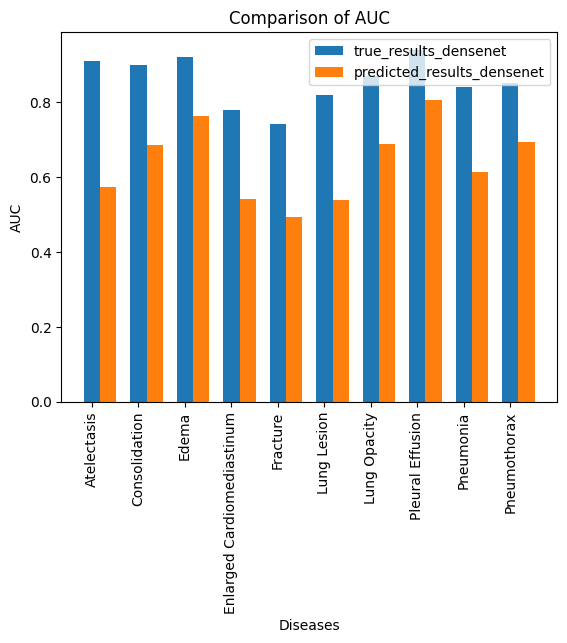

In [496]:

# Extract diseases and AUC values
diseases = list(true_results_densenet.keys())
values1 = [true_results_densenet[disease] for disease in diseases]
values2 = [auc[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.35

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(positions, values1, width=bar_width, label='true_results_densenet')
bar2 = ax.bar(positions + bar_width, values2, width=bar_width, label='predicted_results_densenet')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel('AUC')
ax.set_title('Comparison of AUC')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()


### Study a metric

In [497]:
met = 'AUC'
diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 
            'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
            'Pleural Effusion', 'Fracture']

In [498]:
# Compute metrics for each disease
auc = {}
for disease in diseases:
    pred_column = disease + ' pred'
    if pred_column in df.columns:  # Check if prediction column exists
        metrics = compute_metrics(df[disease], df[pred_column])
        auc[disease] = metrics[met]

print(f"General {met}", auc)

General AUC {'No Finding': 0.550481634833274, 'Enlarged Cardiomediastinum': 0.5406171207692907, 'Lung Opacity': 0.6889017764748885, 'Lung Lesion': 0.5382194518729119, 'Edema': 0.7631662606242009, 'Consolidation': 0.6864341858160165, 'Pneumonia': 0.6119332990653117, 'Atelectasis': 0.5725357886991319, 'Pneumothorax': 0.6944656083686456, 'Pleural Effusion': 0.8066390054135135, 'Fracture': 0.491865445377058}


In [499]:
# Initialize dictionaries to store AUC values
auc_female = {}
auc_male = {}

# Filter DataFrame by sex and compute AUC for each disease
for sex, auc_dict in [(1, auc_female), (0, auc_male)]:
    df_sex = df[df['sex'] == sex]
    for disease in diseases:
        pred_column = disease + ' pred'
        if pred_column in df_sex.columns:
            metrics = compute_metrics(df_sex[disease], df_sex[pred_column])
            auc_dict[disease] = metrics[met]

# Output results
print(f"{met} for Females: {auc_female}")
print(f"{met} for Males: {auc_male}")


AUC for Females: {'No Finding': 0.5574711852134596, 'Enlarged Cardiomediastinum': 0.536922263218435, 'Lung Opacity': 0.6867041287250962, 'Lung Lesion': 0.5537861357142493, 'Edema': 0.7646455682744767, 'Consolidation': 0.7022291563290621, 'Pneumonia': 0.601410449916011, 'Atelectasis': 0.5760293792026429, 'Pneumothorax': 0.7021545028618994, 'Pleural Effusion': 0.8167069549287568, 'Fracture': 0.521136171245369}
AUC for Males: {'No Finding': 0.5450823132123258, 'Enlarged Cardiomediastinum': 0.542549676859265, 'Lung Opacity': 0.690500770538405, 'Lung Lesion': 0.527956913410761, 'Edema': 0.7620228968292115, 'Consolidation': 0.675256711074373, 'Pneumonia': 0.6204153312534815, 'Atelectasis': 0.5695560180894856, 'Pneumothorax': 0.6885698457800021, 'Pleural Effusion': 0.7991522491272786, 'Fracture': 0.4712673121482732}


In [500]:
# Initialize dictionaries to store AUC values
auc_white = {}
auc_black = {}
auc_asian = {}

# Filter DataFrame by sex and compute AUC for each disease
for race, auc_dict in [(0, auc_white), (1, auc_asian), (2, auc_black)]: 
    df_race = df[df['race'] == race]
    for disease in diseases:
        pred_column = disease + ' pred'
        if pred_column in df_sex.columns:
            metrics = compute_metrics(df_race[disease], df_race[pred_column])
            auc_dict[disease] = metrics[met]

# Output results
print(f"{met} for W: {auc_white}")
print(f"{met} for B: {auc_black}")
print(f"{met} for A: {auc_asian}")


AUC for W: {'No Finding': 0.5485934682415834, 'Enlarged Cardiomediastinum': 0.5414713092476975, 'Lung Opacity': 0.6851601592076175, 'Lung Lesion': 0.5234370228110978, 'Edema': 0.7651805078385951, 'Consolidation': 0.6833272539804306, 'Pneumonia': 0.6172223159688965, 'Atelectasis': 0.5691253170520088, 'Pneumothorax': 0.6890565743648926, 'Pleural Effusion': 0.8036043551916574, 'Fracture': 0.49191943005153793}
AUC for B: {'No Finding': 0.55135132697061, 'Enlarged Cardiomediastinum': 0.5365177585572323, 'Lung Opacity': 0.7110869409062759, 'Lung Lesion': 0.5754484169977128, 'Edema': 0.7388100121727412, 'Consolidation': 0.6993702787560119, 'Pneumonia': 0.5871316631718354, 'Atelectasis': 0.5809558524875285, 'Pneumothorax': 0.7346060106285506, 'Pleural Effusion': 0.8094342597431249, 'Fracture': 0.48505830219501667}
AUC for A: {'No Finding': 0.5588280000336343, 'Enlarged Cardiomediastinum': 0.5390197789601037, 'Lung Opacity': 0.696451540170156, 'Lung Lesion': 0.577921645699552, 'Edema': 0.770508

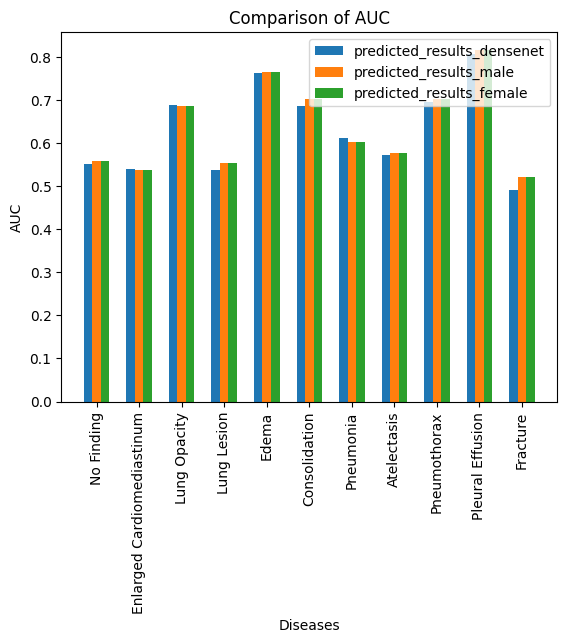

In [501]:

# Extract diseases and AUC values
diseases = list(auc.keys())
values2 = [auc[disease] for disease in diseases]
values_male = [auc_female[disease] for disease in diseases]
values_female = [auc_female[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions, values_male, width=bar_width, label='predicted_results_male')
bar4 = ax.bar(positions + bar_width, values_female, width=bar_width, label='predicted_results_female')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()


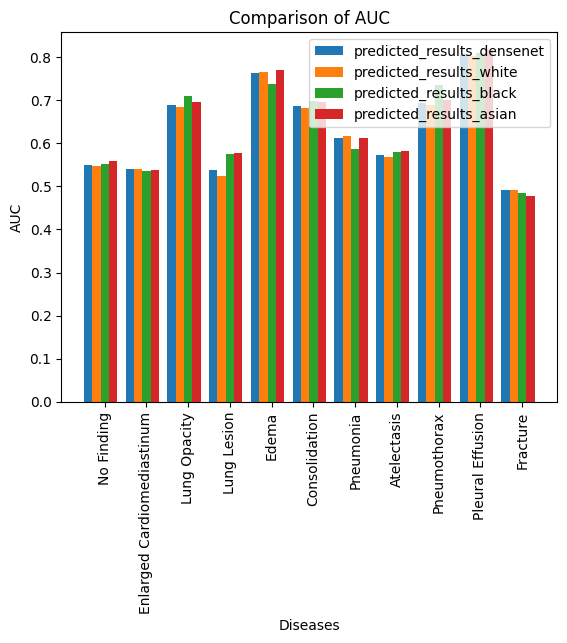

In [502]:

# Extract diseases and AUC values
diseases = list(auc.keys())
values2 = [auc[disease] for disease in diseases]
values_white = [auc_white[disease] for disease in diseases]
values_black = [auc_black[disease] for disease in diseases]
values_asian = [auc_asian[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - 2*bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions - bar_width, values_white, width=bar_width, label='predicted_results_white')
bar4 = ax.bar(positions, values_black, width=bar_width, label='predicted_results_black')
bar5 = ax.bar(positions + bar_width, values_asian, width=bar_width, label='predicted_results_asian')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()
